In [1]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## Topic Modeling In N L P: Topic Modeling - 2 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
# =================================================-
#### Slide 2/21: Load packages  ####

# Builtin packages.
from pathlib import Path
from pprint import pprint

# 3rd party packages.
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download(["punkt", "stopwords"])

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# =================================================-
#### Slide 3/21: Directory settings  ####

# Set 'main_dir' to location of the project folder
# Path("data").mkdir(exist_ok=True)
Path("plot").mkdir(exist_ok=True)

In [5]:
# =================================================-
#### Slide 5/21: Load data  ####

# Let's load and prepare the dataset for creating Document-Term Matrix
df = pd.read_csv("data/NYT_article_data.csv")
df.head()

,web_url,headline,snippet,word_count,source,type_of_material,date,id
0,https://www.nytimes.com/reuters/2019/01/01/spo...,"Kyrgios, Murray Power Into Second Round in Bri...",Nick Kyrgios started his Brisbane Open title d...,435,Reuters,News,2019-01-01,8
1,https://www.nytimes.com/reuters/2019/01/01/wor...,UK Police Treating Manchester Stabbing Attack ...,British police confirmed on Tuesday they were ...,81,Reuters,News,2019-01-01,9
2,https://www.nytimes.com/aponline/2019/01/01/sp...,Former NFL Player Wiley Talks Playoffs on Podc...,Marcellus Wiley is still on the fence about le...,272,AP,News,2019-01-01,10
3,https://www.nytimes.com/2019/01/09/arts/design...,"After the Quake, Dana Schutz Gets Back to Work",Still reckoning with the fallout from her Emme...,1540,The New York Times,News,2019-01-09,11
4,https://www.nytimes.com/aponline/2019/01/10/sp...,Ogunbowale Helps Irish Beat Cardinals in 1-2 S...,As far as Arike Ogunbowale and coach Muffet Mc...,1059,AP,News,2019-01-11,12


In [6]:
# =================================================-
#### Slide 6/21: Check for NAs  ####

# Print total number of NAs.
print(df["snippet"].isna().sum())
# Drop NAs if any.
df = df.dropna(subset=["snippet"]).reset_index(drop=True)
print(df["snippet"].isna().sum())
# Isolate the `snippet` column.
df_text = df["snippet"]

0
0


In [7]:
# =================================================-
#### Slide 7/21: Tokenization: split each document into words  ####

# Tokenize each document into a large list of tokenized documents.
df_tokenized = [word_tokenize(df_text[i]) for i in range(0, len(df_text))]

In [8]:
# =================================================-
#### Slide 9/21: Convert characters to lowercase  ####

# Let's take a look at the first tokenized document
document_words = df_tokenized[0]
print(document_words)
# 1. Convert to lowercase.
document_words = [word.lower() for word in document_words]
print(document_words[:10])

['Nick', 'Kyrgios', 'started', 'his', 'Brisbane', 'Open', 'title', 'defense', 'with', 'a', 'battling', '7-6', '(', '5', ')', '5-7', '7-6', '(', '5', ')', 'victory', 'over', 'American', 'Ryan', 'Harrison', 'in', 'the', 'opening', 'round', 'on', 'Tuesday', '.']
['nick', 'kyrgios', 'started', 'his', 'brisbane', 'open', 'title', 'defense', 'with', 'a']


In [9]:
# =================================================-
#### Slide 10/21: Remove stop words  ####

# 2. Remove stop words.
# Get common English stop words.
stop_words = stopwords.words("english")
print(stop_words[:10])
# Remove stop words.
document_words = [word for word in document_words if not word in stop_words]
print(document_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
['nick', 'kyrgios', 'started', 'brisbane', 'open', 'title', 'defense', 'battling', '7-6', '(']


In [10]:
# =================================================-
#### Slide 11/21: Remove non-alphabetical characters  ####

# 3. Remove punctuation and any non-alphabetical characters.
document_words = [word for word in document_words if word.isalpha()]
print(document_words[:10])

['nick', 'kyrgios', 'started', 'brisbane', 'open', 'title', 'defense', 'battling', 'victory', 'american']


In [11]:
# =================================================-
#### Slide 14/21: Stem words  ####

# 4. Stem words.
document_words = [PorterStemmer().stem(word) for word in document_words]
print(document_words[:10])

['nick', 'kyrgio', 'start', 'brisban', 'open', 'titl', 'defens', 'battl', 'victori', 'american']


In [12]:
# =================================================-
#### Slide 16/21: Clean the entire corpus  ####

# Create a list for clean documents.
df_clean = [None] * len(df_tokenized)
# Create a list of word counts for each clean document.
word_counts_per_document = [None] * len(df_tokenized)

# Process words in all documents.
for i in range(len(df_tokenized)):
    # 1. Convert to lowercase.
    df_clean[i] = [document.lower() for document in df_tokenized[i]]

    # 2. Remove stop words.
    df_clean[i] = [word for word in df_clean[i] if not word in stop_words]

    # 3. Remove punctuation and any non-alphabetical characters.
    df_clean[i] = [word for word in df_clean[i] if word.isalpha()]

    # 4. Stem words.
    df_clean[i] = [PorterStemmer().stem(word) for word in df_clean[i]]

    # Record the word count per document.
    word_counts_per_document[i] = len(df_clean[i])

In [13]:
# =================================================-
#### Slide 17/21: Clean the entire corpus (cont'd)  ####

# Convert word counts list and documents list to NumPy arrays.
word_counts_array = np.array(word_counts_per_document)
df_array = np.array(df_clean, dtype=object)

# Find indices of all documents where there are greater than or equal to 5 words.
valid_documents = np.where(word_counts_array >= 5)[0]

# Subset the df_array to keep only those where there are at least 5 words.
df_array = df_array[valid_documents]

# Convert the array back to a list.
df_clean = df_array.tolist()  # <- the processed documents

print(df_clean[0:2])

# Convert word counts list and documents list to NumPy arrays.
word_counts_array = np.array(word_counts_per_document)
df_array = np.array(df_clean, dtype=object)

[['nick', 'kyrgio', 'start', 'brisban', 'open', 'titl', 'defens', 'battl', 'victori', 'american', 'ryan', 'harrison', 'open', 'round', 'tuesday'], ['british', 'polic', 'confirm', 'tuesday', 'treat', 'stab', 'attack', 'injur', 'three', 'peopl', 'manchest', 'victoria', 'train', 'station', 'terrorist', 'investig', 'search', 'address', 'cheetham', 'hill', 'area', 'citi']]


In [14]:
# =================================================-
#### Slide 18/21: Clean corpus  ####

# Print the first 5 documents of clean corpus
df_array[:5]


#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################

array([list(['nick', 'kyrgio', 'start', 'brisban', 'open', 'titl', 'defens', 'battl', 'victori', 'american', 'ryan', 'harrison', 'open', 'round', 'tuesday']),
       list(['british', 'polic', 'confirm', 'tuesday', 'treat', 'stab', 'attack', 'injur', 'three', 'peopl', 'manchest', 'victoria', 'train', 'station', 'terrorist', 'investig', 'search', 'address', 'cheetham', 'hill', 'area', 'citi']),
       list(['marcellu', 'wiley', 'still', 'fenc', 'let', 'young', 'son', 'play', 'footbal', 'former', 'nfl', 'defens', 'end', 'fox', 'sport', 'person', 'tell', 'podcaston', 'sport', 'like', 'nfl', 'tri', 'make', 'footbal', 'safer', 'game', 'de']),
       list(['still', 'reckon', 'fallout', 'emmett', 'till', 'paint', 'chasten', 'artist', 'reveal', 'controversi', 'chang', 'even', 'move', 'forward', 'new', 'galleri', 'show']),
       list(['far', 'arik', 'ogunbowal', 'coach', 'muffet', 'mcgraw', 'concern', 'notr', 'dame', 'victori', 'louisvil', 'thursday', 'night', 'anoth', 'atlant', 'coast', 'confe

In [15]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## Topic Modeling In N L P: Topic Modeling - 3 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs

In [16]:
# =================================================-
#### Slide 2/24: Create a dictionary of counts   ####

# Set the seed.
np.random.seed(1)
dictionary = gensim.corpora.Dictionary(df_clean)

# The loop below iterates through the first 10 items of the dictionary and prints out the key and value.
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 american
1 battl
2 brisban
3 defens
4 harrison
5 kyrgio
6 nick
7 open
8 round
9 ryan
10 start


In [17]:
# =================================================-
#### Slide 3/24: Create a dictionary of counts   ####

dictionary.filter_extremes(no_below=4, no_above=0.5, keep_n=200)

# How many words are left in the dictionary?
len(dictionary)

200

In [18]:
# =================================================-
#### Slide 4/24: Document to bag-of-words  ####

# We use a list comprehension to transform each doc within our df_clean object.
bow_corpus = [dictionary.doc2bow(doc) for doc in df_clean]

# Let's look at the first document.
print(bow_corpus[0])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1)]


In [19]:
# =================================================-
#### Slide 5/24: Document to bag-of-words (cont'd)  ####

# Isolate the first document.
bow_doc_1 = bow_corpus[0]

# Iterate through each dictionary item using the index.
# Print out each actual word and how many times it appears.
for i in range(len(bow_doc_1)):
    print(
        'Word {} ("{}") appears {} time.'.format(
            bow_doc_1[i][0], dictionary[bow_doc_1[i][0]], bow_doc_1[i][1]
        )
    )

Word 0 ("american") appears 1 time.
Word 1 ("defens") appears 1 time.
Word 2 ("open") appears 2 time.
Word 3 ("round") appears 1 time.
Word 4 ("start") appears 1 time.
Word 5 ("tuesday") appears 1 time.
Word 6 ("victori") appears 1 time.


In [20]:
# =================================================-
#### Slide 7/24: Transform counts with TfidfModel (cont'd)  ####

# This is the transformation.
tfidf = models.TfidfModel(bow_corpus)

# Apply the transformation to the entire corpus.
corpus_tfidf = tfidf[bow_corpus]

# Preview TF-IDF scores for the first document.
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.31942373876087665),
 (1, 0.3549009519669791),
 (2, 0.6118718565633235),
 (3, 0.3549009519669791),
 (4, 0.3059359282816618),
 (5, 0.22829905152454918),
 (6, 0.3549009519669791)]


In [21]:
# =================================================-
#### Slide 11/24: Running LdaMulticore  ####

lda_model_tfidf = gensim.models.LdaMulticore(
    corpus_tfidf, num_topics=5, id2word=dictionary, workers=4, passes=2
)
lda_model_tfidf

In [22]:
# =================================================-
#### Slide 12/24: LDA output  ####

for idx, topic in lda_model_tfidf.print_topics(-1):
    print(f"Topic: {idx} Word: {topic}")

Topic: 0 Word: 0.020*"offici" + 0.020*"like" + 0.017*"say" + 0.017*"week" + 0.017*"warn" + 0.015*"show" + 0.015*"state" + 0.014*"thursday" + 0.014*"help" + 0.014*"new"
Topic: 1 Word: 0.023*"time" + 0.023*"latest" + 0.022*"world" + 0.021*"local" + 0.020*"new" + 0.016*"year" + 0.015*"meet" + 0.013*"york" + 0.013*"tenni" + 0.013*"leader"
Topic: 2 Word: 0.021*"said" + 0.020*"friday" + 0.018*"billion" + 0.018*"know" + 0.015*"set" + 0.015*"say" + 0.013*"accus" + 0.012*"want" + 0.012*"govern" + 0.012*"court"
Topic: 3 Word: 0.020*"investig" + 0.020*"saturday" + 0.019*"presid" + 0.017*"polic" + 0.014*"said" + 0.014*"expect" + 0.013*"citi" + 0.013*"suspect" + 0.013*"year" + 0.013*"first"
Topic: 4 Word: 0.022*"young" + 0.020*"tuesday" + 0.018*"look" + 0.018*"said" + 0.016*"talk" + 0.016*"close" + 0.015*"move" + 0.015*"new" + 0.015*"south" + 0.014*"year"


In [23]:
# =================================================-
#### Slide 13/24: Classify our documents within topics  ####

# Let's look at our first document as an example:
print(df_clean[0])
for index, score in sorted(
    lda_model_tfidf[corpus_tfidf[0]], key=lambda tup: -1 * tup[1]
):
    print(
        f"\nScore: {score}\t "
        f"\nTopic: {lda_model_tfidf.print_topic(index, 10)}"
    )

['nick', 'kyrgio', 'start', 'brisban', 'open', 'titl', 'defens', 'battl', 'victori', 'american', 'ryan', 'harrison', 'open', 'round', 'tuesday']

Score: 0.7646151185035706	 
Topic: 0.020*"investig" + 0.020*"saturday" + 0.019*"presid" + 0.017*"polic" + 0.014*"said" + 0.014*"expect" + 0.013*"citi" + 0.013*"suspect" + 0.013*"year" + 0.013*"first"

Score: 0.06096296012401581	 
Topic: 0.020*"offici" + 0.020*"like" + 0.017*"say" + 0.017*"week" + 0.017*"warn" + 0.015*"show" + 0.015*"state" + 0.014*"thursday" + 0.014*"help" + 0.014*"new"

Score: 0.058861661702394485	 
Topic: 0.022*"young" + 0.020*"tuesday" + 0.018*"look" + 0.018*"said" + 0.016*"talk" + 0.016*"close" + 0.015*"move" + 0.015*"new" + 0.015*"south" + 0.014*"year"

Score: 0.05789513513445854	 
Topic: 0.023*"time" + 0.023*"latest" + 0.022*"world" + 0.021*"local" + 0.020*"new" + 0.016*"year" + 0.015*"meet" + 0.013*"york" + 0.013*"tenni" + 0.013*"leader"

Score: 0.05766509845852852	 
Topic: 0.021*"said" + 0.020*"friday" + 0.018*"billio

In [24]:
# =================================================-
#### Slide 17/24: Calculate topic coherence  ####

# Compute Coherence Score using c_v.
coherence_model_lda = CoherenceModel(
    model=lda_model_tfidf,
    texts=df_clean,
    dictionary=dictionary,
    coherence="c_v",
)
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)

Coherence Score:  0.5082391247655911


In [25]:
start = 2
stop = 40
step = 1
np.random.seed(1)
model_list, coherence_scores = zip(*[
    (
        (model := gensim.models.LdaMulticore(
            corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)),
        CoherenceModel(model=model, texts=df_clean, dictionary=dictionary, coherence="c_v").get_coherence()
    ) for num_topics in range(start, stop, step)
])

In [26]:
# =================================================-
#### Slide 19/24: Convenience function  ####


# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model = gensim.models.LdaMulticore(
#             corpus=corpus, id2word=dictionary, num_topics=num_topics
#         )
#         model_list.append(model)
#         coherencemodel = CoherenceModel(
#             model=model, texts=texts, dictionary=dictionary, coherence="c_v"
#         )
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values

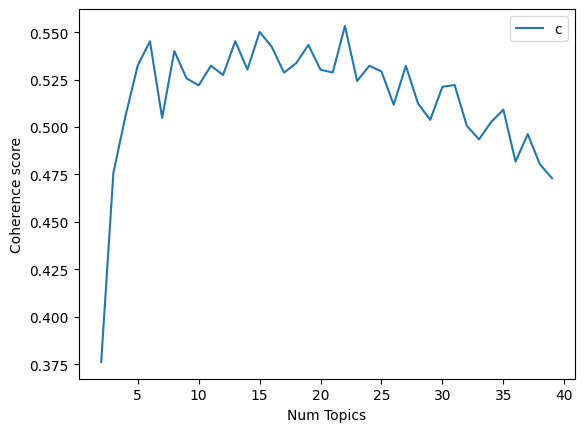

In [27]:
# =================================================-
#### Slide 20/24: Run compute_coherence_values function  ####

# np.random.seed(1)
# model_list, coherence_values = compute_coherence_values(
#     dictionary=dictionary,
#     corpus=corpus_tfidf,
#     texts=df_clean,
#     start=2,
#     limit=40,
#     step=1,
# )
# Plot graph of topic list.
# Show graph.

x = range(start, stop, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()


#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################

In [28]:
chosen_model = model_list[pd.Series(coherence_scores, index=range(start, stop, step)).head(11).idxmax()]

In [29]:
chosen_model = model_list[list(x)[np.argmax(coherence_scores[:11])]]

In [30]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## Topic Modeling In N L P: Topic Modeling - 4 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs

In [31]:
# =================================================-
#### Slide 5/29: Visualize topics generated with LDA  ####

# Prepare LDA vis object by providing:
vis = pyLDAvis.gensim.prepare(
    chosen_model, corpus_tfidf, dictionary
)
# The function takes `vis` object that we prepared above as the main argument.
pyLDAvis.display(vis)

In [32]:
# =================================================-
#### Slide 16/29: Get topic probabilities for a document  ####

# Select the index of the document in corpus.
doc_num = 0
# Extract the vector of tf_idf weights for the document.
doc_vec = corpus_tfidf[doc_num]
print(doc_vec)
# Extract topic probabilities for that document.
doc_topics = lda_model_tfidf.get_document_topics(doc_vec)
print(doc_topics)
topic, prob = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0]

[(0, 0.31942373876087665), (1, 0.3549009519669791), (2, 0.6118718565633235), (3, 0.3549009519669791), (4, 0.3059359282816618), (5, 0.22829905152454918), (6, 0.3549009519669791)]
[(0, 0.06096654), (1, 0.0578951), (2, 0.05766507), (3, 0.76461583), (4, 0.058857445)]


In [33]:
# =================================================-
#### Slide 17/29: Get topic probabilities for a document (cont'd)  ####

# Initialize maximum probability score.
max_prob = 0
# Initialize best topic.
best_topic = 0

# Loop over all topics for the document.
for topic in doc_topics:

    if max_prob <= topic[1]:  # <- if current topic's probability is as high as max
        max_prob = topic[1]  # <- make current topic's probability the new max
        best_topic = topic[0]  # <- make current topic best

# Create a tuple with information we just got.
doc_topic_pair = (doc_num, best_topic, max_prob)
print(doc_topic_pair)

(0, 3, 0.76461583)


In [34]:
# =================================================-
#### Slide 18/29: Get topic probabilities for a document (cont'd)  ####


# Put it all together into a function that returns a tuple
# with the index of the document, the best fit topic, and its probability.
def GetDocTopicPair(doc_num, corpus, lda_model_tfidf):
    # Extract the vector of tf_idf weights for the document.
    doc_vec = corpus[doc_num]
    # Extract topic probabilities for that document.
    doc_topics = lda_model_tfidf.get_document_topics(doc_vec)
    max_prob = 0
    best_topic = 0
    for topic in doc_topics:
        if max_prob <= topic[1]:
            max_prob = topic[1]
            best_topic = topic[0]
    doc_topic_pair = (doc_num, best_topic, max_prob)
    return doc_topic_pair

In [35]:
# =================================================-
#### Slide 19/29: Get topic probabilities for all documents  ####

# Create an empty list of the same length as the number of documents.
doc_topic_pairs = [None] * dictionary.num_docs

# Loop through a range of document indices.
for i in range(dictionary.num_docs):
    # For each document index, get the document-topic tuple.
    doc_topic_pairs[i] = GetDocTopicPair(i, corpus_tfidf, lda_model_tfidf)

print(doc_topic_pairs[:10])

[(0, 3, 0.7645485), (1, 3, 0.78746754), (2, 4, 0.79786205), (3, 4, 0.7597613), (4, 4, 0.6015693), (5, 0, 0.6989494), (6, 0, 0.597932), (7, 1, 0.72207123), (8, 0, 0.7621833), (9, 1, 0.7705078)]


In [36]:
# =================================================-
#### Slide 20/29: Create a data frame with doc-topic assignments  ####

# Make a dataframe out of a list of tuples.
doc_topic_pairs_df = pd.DataFrame(doc_topic_pairs)

# Assign column names to the dataframe.
doc_topic_pairs_df.columns = ["doc_id", "best_topic", "best_probability"]
print(doc_topic_pairs_df.head())

   doc_id  best_topic  best_probability
0       0           3          0.764548
1       1           3          0.787468
2       2           4          0.797862
3       3           4          0.759761
4       4           4          0.601569


In [37]:
# =================================================-
#### Slide 21/29: Matching document ids to original data  ####

# Find indices of documents that we kept.
valid_documents = np.where(word_counts_array >= 5)[0]
# Now assign the index of the original document to be the index of the dataframe.
doc_topic_pairs_df.index = valid_documents
print(doc_topic_pairs_df.iloc[0:10,])

   doc_id  best_topic  best_probability
0       0           3          0.764548
1       1           3          0.787468
2       2           4          0.797862
3       3           4          0.759761
4       4           4          0.601569
5       5           0          0.698949
6       6           0          0.597932
7       7           1          0.722071
8       8           0          0.762183
9       9           1          0.770508


In [38]:
# =================================================-
#### Slide 22/29: Inspect documents for a given topic  ####

# Filter and sort all documents assigned to topic 3 by probability in descending order.
topic3_docs = doc_topic_pairs_df.query("best_topic==2")
topic3_docs = topic3_docs.sort_values(by="best_probability", ascending=False)
print(topic3_docs.head())
# Let's see how many documents were assigned to that topic.
print(topic3_docs.shape)

     doc_id  best_topic  best_probability
221     219           2          0.806268
145     143           2          0.804149
68       68           2          0.802440
164     162           2          0.799955
97       97           2          0.798230
(39, 3)


In [39]:
# =================================================-
#### Slide 23/29: Inspect documents for a given topic (cont'd)  ####

# Let's get the top 10 documents that were assigned to that topic.
top_10 = topic3_docs.index[0:10,]
# Inspect the top 10 documents in topic 3.
df_topic3 = df.loc[top_10, :]
print(df_topic3[["snippet"]])

                                               snippet
221  Job openings are outnumbering unemployed worke...
145  India's central bank, having changed leadershi...
68   Greece's public order minister strongly critic...
164  Britain is testing how its motorway and ferry ...
97   India's Supreme Court is likely to name a pane...
125  Global stocks soared Friday and reversed the b...
203  SoftBank Group Corp will inject another $2 bil...
41   China's population is set to reach a peak of 1...
142  Thousands of demonstrators marched in Hong Kon...
80   An executive at a San Diego television station...


In [40]:
# =================================================-
#### Slide 24/29: Save LDA visualization to HTML file  ####

# Save the plot as a self-contained HTML file.
pyLDAvis.save_html(vis, "plot/df_LDAvis.html")

In [41]:
# =================================================-
#### Slide 26/29: Exercise  ####


#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################